In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from geopy import distance
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
'''Restautant examples: Longitude, latitude name, main menu, average price'''
restaurant_list = [[116.359078, 39.981472, '宏状元现熬粥','八宝粥 皮蛋瘦肉粥 牛肉饼 肉丝焖面',40.50],
                   [116.325020, 39.998871, '李先生牛肉面','招牌牛肉面 牛肉酱拌面 黄金小酥肉',42.10],
                   [116.370262, 39.979382, '北平楼','北京烤鸭 疙瘩汤 炝炒土豆丝 酥皮虾 小炒芸豆丝',163.93],
                   [116.353430, 40.001771, '赛百味·三明治','牛肉三明治 鸡腿肉三明治 香肠三明治',41.07],
                   [116.337764, 39.975807, '好嫂子','酱猪手 炖排骨 红烧肉西红柿鸡蛋双拼 牛腩胡萝卜土豆饭',69.53],
                   [116.322937, 39.965422, '巴黎贝甜','原味贝果 黄油早餐面包 白吐司 菠萝酥面包 巧克力蛋糕',62.93],
                   [116.359899, 40.001519, '鱼籽村秘制拌饭','微辣鱼籽拌饭 中辣鱼籽拌饭',26.74],
                   [116.361514, 39.981571, '庆丰包子铺','素三鲜包 鲜虾菜心包 鲜肉小笼包 猪肉梅干菜包子',36.82],
                   [116.355091, 40.008520, '1点点','珍珠奶茶 抹茶奶茶 葡萄柚绿水果茶 苹果茉莉绿茶',27.44],
                   [116.306740, 39.968101, '淮王小哥哥烤冷面','香肠烤冷面 双蛋煎饼 烤肠 手抓饼',19.00],
                   [116.323100, 39.968020, '叫了只炸鸡','炸鸡 炸鸡翅 炸鸡腿 韩式炸鸡',23.68],
                   [116.336911, 39.992001, '第1佳大鸡排','炸鸡排 香酥鸡柳 香辣鸡腿汉堡 烤冷面',27.20],
                   [116.33122,  39.993366, '库迪咖啡','生椰拿铁 茉莉拿铁 拿铁咖啡 美式咖啡',19.50],
                   [116.339267, 39.992244, 'CoCo都可','黑糖珍珠奶茶 百香果水果茶 双倍鲜芋奶绿奶茶 红豆奶茶',22.00],
                   [116.319786, 39.967868, '津卫·天津煎饼果子','天津煎饼果子 鲜肉小笼包 原味豆浆',26.80],
                   [116.341996, 39.970232, '金百万烤鸭·春饼','北京烤鸭 地三鲜 宫保鸡丁 木须肉',54.87],
                   [116.334120, 39.993903, '东方宫兰州牛肉拉面','传统牛肉拉面 羊肉串 大盘鸡拌面',31.38],
                   [116.339285, 39.991921, '云海肴·汽锅鸡','原味汽锅鸡 洋芋焖饭套餐 油焖鸡 菌菇炒牛肉 宣威小炒肉',53.19],
                   [116.339331, 39.991753, '汤城小厨','香辣乳鸽 煲仔饭 酸汤鱼 珍菌牛仔粒 三杯鸡 蒜香鸡脆骨',116.83],
                   [116.351937, 39.999860, '凉皮先生','传统凉皮 浓汤米线 肉夹馍',25.85],
                   [116.372580, 40.010090, '华莱士·全鸡汉堡','香辣鸡排汉堡 风味鸡腿汉堡 薯条 可乐 烤鸡翅',25.77],
                   [116.353402,40.009659, '峨嵋酒家','宫保鸡丁 樟茶鸭 东坡肘子 精品烤鸭 清蒸鲈鱼 干烧大黄鱼',133.88]
                   ]

# spatial adjacency

In [3]:
spatial_adjacency = np.zeros([len(restaurant_list), len(restaurant_list)])
for kk in range(len(restaurant_list)):
    loc1 = (restaurant_list[kk][1], restaurant_list[kk][0])
    for nn in range(len(restaurant_list)):
        loc2 = (restaurant_list[nn][1], restaurant_list[nn][0])
        spatial_adjacency[kk,nn] = distance.distance(loc1,loc2).m
        
np.save("spatial_adjacency_example.npy", spatial_adjacency)

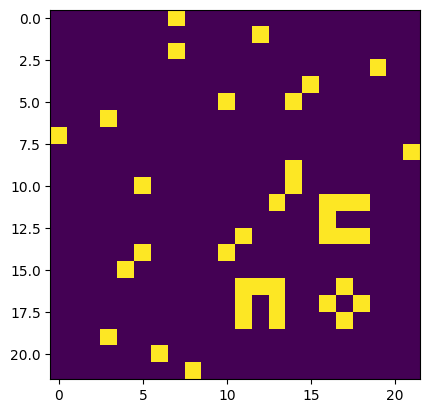

In [4]:
spatial_binary_adjacency = np.zeros([len(restaurant_list), len(restaurant_list)])

for kk in range(len(restaurant_list)):
    set1 = np.where(spatial_adjacency[kk]<=500)[0]
    set2 = np.argsort(spatial_adjacency[kk])[0:int(len(restaurant_list)*0.10)]  # Adjustable threshold
    union = np.union1d(set1, set2)
    for nn in union:
        if nn!=kk:
            spatial_binary_adjacency[kk,nn] = 1
np.save("spatial_binary_adjacency.npy",spatial_binary_adjacency)
plt.imshow(spatial_binary_adjacency,vmin=0, vmax=0.5, cmap='viridis')

# name-menu adjacency 

In [5]:
restaurant_signs = [restaurant_list[kk][2]+" "+restaurant_list[kk][3] for kk in range(len(restaurant_list))]
restaurant_signs

['宏状元现熬粥 八宝粥 皮蛋瘦肉粥 牛肉饼 肉丝焖面',
 '李先生牛肉面 招牌牛肉面 牛肉酱拌面 黄金小酥肉',
 '北平楼 北京烤鸭 疙瘩汤 炝炒土豆丝 酥皮虾 小炒芸豆丝',
 '赛百味·三明治 牛肉三明治 鸡腿肉三明治 香肠三明治',
 '好嫂子 酱猪手 炖排骨 红烧肉西红柿鸡蛋双拼 牛腩胡萝卜土豆饭',
 '巴黎贝甜 原味贝果 黄油早餐面包 白吐司 菠萝酥面包 巧克力蛋糕',
 '鱼籽村秘制拌饭 微辣鱼籽拌饭 中辣鱼籽拌饭',
 '庆丰包子铺 素三鲜包 鲜虾菜心包 鲜肉小笼包 猪肉梅干菜包子',
 '1点点 珍珠奶茶 抹茶奶茶 葡萄柚绿水果茶 苹果茉莉绿茶',
 '淮王小哥哥烤冷面 香肠烤冷面 双蛋煎饼 烤肠 手抓饼',
 '叫了只炸鸡 炸鸡 炸鸡翅 炸鸡腿 韩式炸鸡',
 '第1佳大鸡排 炸鸡排 香酥鸡柳 香辣鸡腿汉堡 烤冷面',
 '库迪咖啡 生椰拿铁 茉莉拿铁 拿铁咖啡 美式咖啡',
 'CoCo都可 黑糖珍珠奶茶 百香果水果茶 双倍鲜芋奶绿奶茶 红豆奶茶',
 '津卫·天津煎饼果子 天津煎饼果子 鲜肉小笼包 原味豆浆',
 '金百万烤鸭·春饼 北京烤鸭 地三鲜 宫保鸡丁 木须肉',
 '东方宫兰州牛肉拉面 传统牛肉拉面 羊肉串 大盘鸡拌面',
 '云海肴·汽锅鸡 原味汽锅鸡 洋芋焖饭套餐 油焖鸡 菌菇炒牛肉 宣威小炒肉',
 '汤城小厨 香辣乳鸽 煲仔饭 酸汤鱼 珍菌牛仔粒 三杯鸡 蒜香鸡脆骨',
 '凉皮先生 传统凉皮 浓汤米线 肉夹馍',
 '华莱士·全鸡汉堡 香辣鸡排汉堡 风味鸡腿汉堡 薯条 可乐 烤鸡翅',
 '峨嵋酒家 宫保鸡丁 樟茶鸭 东坡肘子 精品烤鸭 清蒸鲈鱼 干烧大黄鱼']

In [6]:
# 2. Load pre-trained model (automatically downloaded if not cached)
model_name_or_path = "Alibaba-NLP/gte-multilingual-base"
model = SentenceTransformer(model_name_or_path, trust_remote_code=True)

# 3. Generate text embeddings
embeddings = model.encode(restaurant_signs, convert_to_tensor=True)

# 4. Calculate similarity matrix
# Note: Ensure `cosine_similarity` is imported (e.g., from sklearn.metrics.pairwise import cosine_similarity)
similarity_matrix = cosine_similarity(embeddings.cpu())

# 5. Print results
print("餐厅招牌向量维度:", embeddings[0].shape)   
print("\n相似度矩阵:")
for i, row in enumerate(similarity_matrix):
    print(f"{restaurant_signs[i]:<15} | " + " ".join([f"{x:.3f}" for x in row]))

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\liushan\anaconda3\envs\torch\lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5090 D with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5090 D GPU with PyTo

餐厅招牌向量维度: torch.Size([768])

相似度矩阵:
宏状元现熬粥 八宝粥 皮蛋瘦肉粥 牛肉饼 肉丝焖面 | 1.000 0.623 0.539 0.527 0.588 0.463 0.557 0.486 0.424 0.616 0.420 0.510 0.441 0.444 0.586 0.585 0.572 0.557 0.556 0.591 0.460 0.526
李先生牛肉面 招牌牛肉面 牛肉酱拌面 黄金小酥肉 | 0.623 1.000 0.513 0.575 0.522 0.437 0.486 0.533 0.408 0.624 0.510 0.575 0.403 0.381 0.546 0.573 0.662 0.479 0.575 0.683 0.521 0.510
北平楼 北京烤鸭 疙瘩汤 炝炒土豆丝 酥皮虾 小炒芸豆丝 | 0.539 0.513 1.000 0.490 0.480 0.500 0.524 0.500 0.431 0.545 0.541 0.560 0.374 0.420 0.524 0.672 0.527 0.578 0.548 0.531 0.532 0.615
赛百味·三明治 牛肉三明治 鸡腿肉三明治 香肠三明治 | 0.527 0.575 0.490 1.000 0.503 0.576 0.482 0.515 0.439 0.550 0.559 0.624 0.516 0.412 0.541 0.608 0.499 0.509 0.544 0.520 0.713 0.512
好嫂子 酱猪手 炖排骨 红烧肉西红柿鸡蛋双拼 牛腩胡萝卜土豆饭 | 0.588 0.522 0.480 0.503 1.000 0.381 0.497 0.533 0.409 0.561 0.436 0.498 0.379 0.472 0.496 0.520 0.463 0.536 0.611 0.540 0.425 0.510
巴黎贝甜 原味贝果 黄油早餐面包 白吐司 菠萝酥面包 巧克力蛋糕 | 0.463 0.437 0.500 0.576 0.381 1.000 0.407 0.460 0.497 0.491 0.429 0.470 0.477 0.508 0.500 0.443 0.395 0.388 0.410 0.480 

(array([[ 2.,  5.,  4.,  9.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 3.,  3.,  7.,  4.,  3.,  1.,  0.,  0.,  0.,  1.],
        [ 2.,  2., 13.,  3.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  2., 12.,  4.,  1.,  1.,  0.,  0.,  0.,  1.],
        [ 3.,  5., 10.,  3.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 6.,  8.,  6.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 3.,  7.,  9.,  1.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 2.,  9.,  7.,  3.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 6., 12.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 3.,  1., 10.,  5.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 5.,  4.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 2.,  5.,  4.,  6.,  3.,  1.,  0.,  0.,  0.,  1.],
        [11.,  7.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [10.,  8.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 2.,  6.,  8.,  4.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  3.,  4., 10.,  2.,  1.,  0.,  0.,  0.,  1.],
        [ 2.,  7.,  9.,  2.,  1.,  0.,  

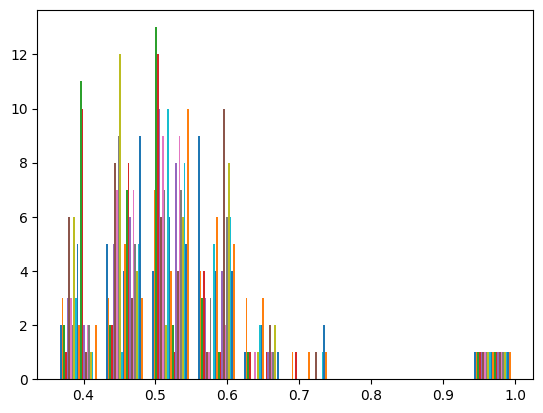

In [7]:
name_menu_embedd = embeddings.cpu().numpy()
np.save("name_menu_embedd.npy",name_menu_embedd)
plt.hist(similarity_matrix)

In [8]:
def find_topk(query_index, similarity_matrix, k=2):
    """find the most similiar k restaurants"""
    sim_scores = similarity_matrix[query_index]
    topk_indices = np.argsort(-sim_scores)[1:k+1]  # Exclude itself
    return topk_indices

query_idx = 4
query_name = restaurant_signs[query_idx]
print("query restaurant:",query_name)
top5_indices = find_topk(query_idx, similarity_matrix)
[restaurant_signs[zx] for zx in top5_indices]

query restaurant: 好嫂子 酱猪手 炖排骨 红烧肉西红柿鸡蛋双拼 牛腩胡萝卜土豆饭


['汤城小厨 香辣乳鸽 煲仔饭 酸汤鱼 珍菌牛仔粒 三杯鸡 蒜香鸡脆骨', '宏状元现熬粥 八宝粥 皮蛋瘦肉粥 牛肉饼 肉丝焖面']

In [9]:
query_idx = 2
query_name = restaurant_signs[query_idx]
print("query restaurant:",query_name)
top5_indices = find_topk(query_idx, similarity_matrix)
[restaurant_signs[zx] for zx in top5_indices]

query restaurant: 北平楼 北京烤鸭 疙瘩汤 炝炒土豆丝 酥皮虾 小炒芸豆丝


['金百万烤鸭·春饼 北京烤鸭 地三鲜 宫保鸡丁 木须肉', '峨嵋酒家 宫保鸡丁 樟茶鸭 东坡肘子 精品烤鸭 清蒸鲈鱼 干烧大黄鱼']

In [10]:
name_menu_adjacency = np.zeros([len(restaurant_list), len(restaurant_list)])
for kk in range(len(restaurant_list)):
    set1 = np.where(similarity_matrix[kk]>=0.70)[0]  
    set2 = np.argsort(-similarity_matrix[kk])[0:int(len(restaurant_list)*0.10)]  # adjustable threshold 
    union = np.union1d(set1, set2)
    for zz in union:
        if kk !=zz:
            name_menu_adjacency[kk,zz]=similarity_matrix[kk,zz]
    print(kk, len(union), union)

0 2 [0 1]
1 2 [ 1 19]
2 2 [ 2 15]
3 2 [ 3 20]
4 2 [ 4 18]
5 2 [3 5]
6 2 [ 6 18]
7 2 [ 7 14]
8 2 [ 8 13]
9 2 [1 9]
10 2 [10 20]
11 2 [11 20]
12 2 [12 13]
13 2 [ 8 13]
14 2 [ 9 14]
15 2 [15 21]
16 2 [ 1 16]
17 2 [17 18]
18 2 [17 18]
19 2 [ 1 19]
20 3 [ 3 11 20]
21 2 [15 21]


In [11]:
np.save("name_menu_adjacency.npy", name_menu_adjacency)

# prcie adjacency

In [12]:
price_adjacency = np.zeros([len(restaurant_list), len(restaurant_list)])
restaurant_average_price = np.array([restaurant_list[zz][4] for zz in range(len(restaurant_list))])
for kk in range(len(restaurant_list)):
    sort_content = np.abs(restaurant_average_price - restaurant_average_price[kk])
    price_neighbour = np.where(sort_content<=max(restaurant_average_price[kk]*0.10,3))[0]
    for zz in price_neighbour:
        if zz!=kk:
            price_adjacency[kk,zz]= 1
    if len(price_neighbour)<2:
        for zz in np.argsort(sort_content)[0:2]:
            if zz!=kk:
                price_adjacency[kk,zz]= 1            

In [13]:
np.save("price_adjacency.npy", price_adjacency)